# Loading Data

In [2]:
import numpy as np

def get_data():
    data = np.genfromtxt('data.csv', delimiter=',')
    X = data[:, 0]
    Y = data[:, 1]
    return X, Y

In [3]:
import json

def load(dataset_path):
    with open(dataset_path,"r") as f:
        data = json.load(f)
    
    inputs = np.array(data["mfcc"])
    targets = np.array(data["labels"])    
    
    return inputs, targets

def get_data():
    return load("data.json")

# Neural Network

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self, inputs):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(inputs.shape[1] * inputs.shape[2], 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.softmax(self.fc4(x))
        return x

In [7]:
inputs, targets = get_data()

model = NeuralNetwork(inputs).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

input_train, input_test, target_train, target_test = train_test_split(inputs, targets, test_size=0.3)

train_dataset = TensorDataset(torch.tensor(input_train, dtype=torch.float32), 
                              torch.tensor(target_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(input_test, dtype=torch.float32), 
                             torch.tensor(target_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

history_nn = {"accuracy": [], "val_accuracy": [], "loss": [], "val_loss": []}
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    history_nn["loss"].append(train_loss)
    history_nn["accuracy"].append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    val_loss /= len(test_loader)
    val_accuracy = correct / total
    history_nn["val_loss"].append(val_loss)
    history_nn["val_accuracy"].append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

Epoch 1/50, Loss: 2.1690, Accuracy: 0.2804, Val Loss: 2.1381, Val Accuracy: 0.3151
Epoch 2/50, Loss: 2.1249, Accuracy: 0.3302, Val Loss: 2.0959, Val Accuracy: 0.3621
Epoch 3/50, Loss: 2.0802, Accuracy: 0.3781, Val Loss: 2.0770, Val Accuracy: 0.3802
Epoch 4/50, Loss: 2.0562, Accuracy: 0.4021, Val Loss: 2.0725, Val Accuracy: 0.3832
Epoch 5/50, Loss: 2.0300, Accuracy: 0.4286, Val Loss: 2.0469, Val Accuracy: 0.4072
Epoch 6/50, Loss: 1.9804, Accuracy: 0.4791, Val Loss: 2.0240, Val Accuracy: 0.4312
Epoch 7/50, Loss: 1.9525, Accuracy: 0.5087, Val Loss: 2.0137, Val Accuracy: 0.4433
Epoch 8/50, Loss: 1.9370, Accuracy: 0.5243, Val Loss: 1.9996, Val Accuracy: 0.4566
Epoch 9/50, Loss: 1.9133, Accuracy: 0.5522, Val Loss: 1.9675, Val Accuracy: 0.4950
Epoch 10/50, Loss: 1.8939, Accuracy: 0.5710, Val Loss: 1.9902, Val Accuracy: 0.4703
Epoch 11/50, Loss: 1.8777, Accuracy: 0.5873, Val Loss: 1.9595, Val Accuracy: 0.5003
Epoch 12/50, Loss: 1.8600, Accuracy: 0.6050, Val Loss: 1.9538, Val Accuracy: 0.5037
E

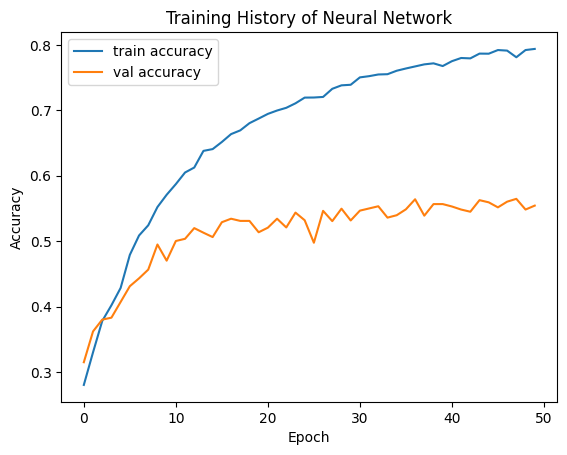

In [8]:
plt.plot(history_nn["accuracy"], label="train accuracy")
plt.plot(history_nn["val_accuracy"], label="val accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Training History of Neural Network")
plt.legend()
plt.show()

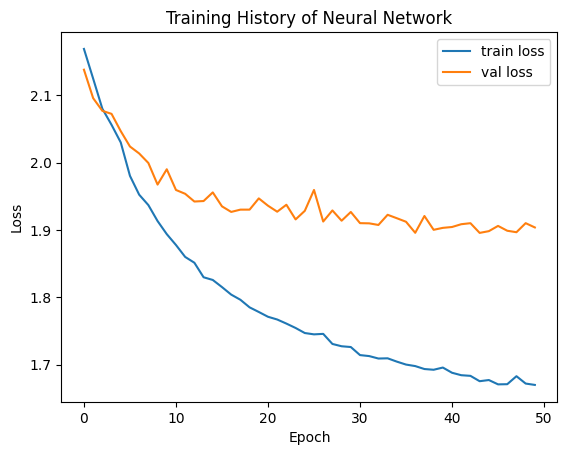

In [9]:
plt.plot(history_nn["loss"], label="train loss")
plt.plot(history_nn["val_loss"], label="val loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training History of Neural Network")
plt.legend()
plt.show()

In [10]:
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

test_loss /= len(test_loader)
test_accuracy_nn = correct / total
print(f"Test accuracy: {test_accuracy_nn}")

Test accuracy: 0.5544058744993324


# Convolutional Neural Network

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3))
        self.pool1 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 32, kernel_size=(3, 3))
        self.pool2 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 32, kernel_size=(2, 2))
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        
        self.conv4 = nn.Conv2d(32, 16, kernel_size=(1, 1))
        self.pool4 = nn.MaxPool2d(kernel_size=(1, 1), stride=(2, 2), padding=0)
        self.bn4 = nn.BatchNorm2d(16)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.bn1(x)
        x = self.pool2(self.relu(self.conv2(x)))
        x = self.bn2(x)
        x = self.pool3(self.relu(self.conv3(x)))
        x = self.bn3(x)
        x = self.pool4(self.relu(self.conv4(x)))
        x = self.bn4(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [12]:
X, y = get_data()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)

y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_epochs = 50
history_cnn = {"accuracy": [], "val_accuracy": [], "loss": [], "val_loss": []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        inputs = inputs.squeeze(-1)  # Removes the last dimension of size 1

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    history_cnn["loss"].append(train_loss)
    history_cnn["accuracy"].append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    history_cnn["val_loss"].append(val_loss)
    history_cnn["val_accuracy"].append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

Epoch 1/50, Loss: 1.9821, Accuracy: 0.2953, Val Loss: 1.7138, Val Accuracy: 0.3738
Epoch 2/50, Loss: 1.6186, Accuracy: 0.4271, Val Loss: 1.4831, Val Accuracy: 0.4693
Epoch 3/50, Loss: 1.4219, Accuracy: 0.4979, Val Loss: 1.3366, Val Accuracy: 0.5387
Epoch 4/50, Loss: 1.2839, Accuracy: 0.5507, Val Loss: 1.2133, Val Accuracy: 0.5868
Epoch 5/50, Loss: 1.1799, Accuracy: 0.5862, Val Loss: 1.1386, Val Accuracy: 0.6175
Epoch 6/50, Loss: 1.1099, Accuracy: 0.6067, Val Loss: 1.1057, Val Accuracy: 0.6228
Epoch 7/50, Loss: 1.0393, Accuracy: 0.6361, Val Loss: 1.0259, Val Accuracy: 0.6475
Epoch 8/50, Loss: 0.9904, Accuracy: 0.6495, Val Loss: 1.0089, Val Accuracy: 0.6542
Epoch 9/50, Loss: 0.9493, Accuracy: 0.6765, Val Loss: 0.9527, Val Accuracy: 0.6702
Epoch 10/50, Loss: 0.9235, Accuracy: 0.6752, Val Loss: 0.9110, Val Accuracy: 0.6842
Epoch 11/50, Loss: 0.8707, Accuracy: 0.6997, Val Loss: 0.9429, Val Accuracy: 0.6802
Epoch 12/50, Loss: 0.8477, Accuracy: 0.7111, Val Loss: 0.8877, Val Accuracy: 0.7043
E

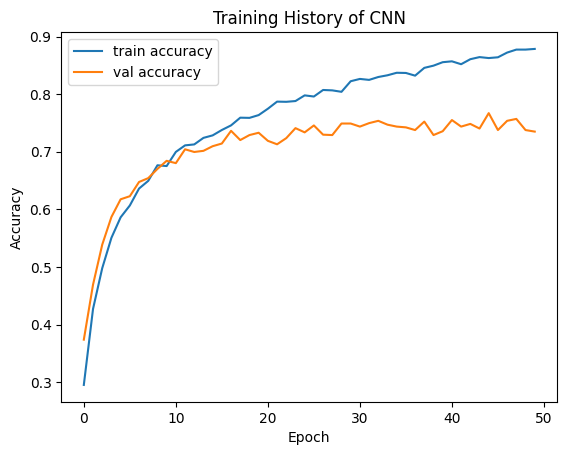

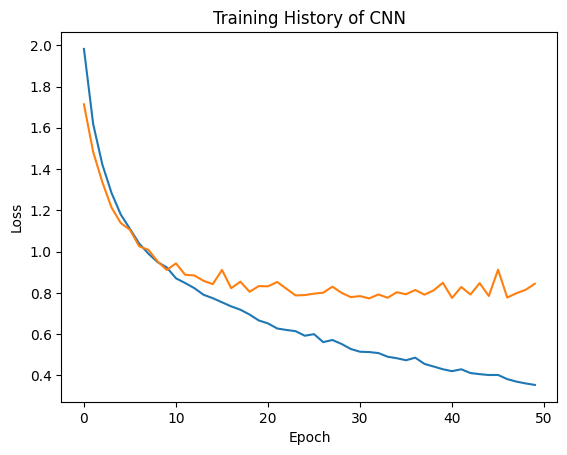

In [13]:
plt.plot(history_cnn["accuracy"], label="train accuracy")
plt.plot(history_cnn["val_accuracy"], label="val accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Training History of CNN")
plt.legend()
plt.show()

plt.plot(history_cnn["loss"], label="train loss")
plt.plot(history_cnn["val_loss"], label="val loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training History of CNN")
plt.legend
plt.show()

In [14]:
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

test_loss /= len(test_loader)
test_accuracy_cnn = correct / total
print(f"Test accuracy: {test_accuracy_cnn}")

Test accuracy: 0.7565078093712455


# Recurrent Neural Network

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2024-12-07 17:06:42.151132: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-07 17:06:42.157931: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733609202.165983   53455 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733609202.168422   53455 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-07 17:06:42.177070: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [16]:
inputs, targets = get_data()

X_train_full, X_test, y_train_full, y_test = train_test_split(inputs, targets, test_size=0.3)

# One-hot encode labels
y_train_full = to_categorical(y_train_full, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Reshape data for RNN input (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], -1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], -1)

In [17]:
# Build RNN model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(128, return_sequences=True),
    Dropout(0.3),

    LSTM(64, return_sequences=False),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(10, activation='softmax')  # 10 classes for music genres
])

# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

I0000 00:00:1733609206.159906   53455 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2262 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 3GB, pci bus id: 0000:01:00.0, compute capability: 6.1


In [18]:
# Train model
model_history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32
)

# Evaluate model
model_loss, model_accuracy = model.evaluate(X_test, y_test)
print(f"Model Test Loss: {model_loss}")
print(f"Model Test Accuracy: {model_accuracy}")

Epoch 1/50


I0000 00:00:1733609207.633980   53746 cuda_dnn.cc:529] Loaded cuDNN version 90300


175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.2598 - loss: 2.0353 - val_accuracy: 0.4485 - val_loss: 1.5194
Epoch 2/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4241 - loss: 1.5881 - val_accuracy: 0.5150 - val_loss: 1.3686
Epoch 3/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4914 - loss: 1.3960 - val_accuracy: 0.5422 - val_loss: 1.2710
Epoch 4/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5237 - loss: 1.3389 - val_accuracy: 0.5715 - val_loss: 1.1828
Epoch 5/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5566 - loss: 1.2446 - val_accuracy: 0.5866 - val_loss: 1.1417
Epoch 6/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5628 - loss: 1.2455 - val_accuracy: 0.6202 - val_loss: 1.0817
Epoch 7/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6111 - loss: 1.1104 - val_accuracy: 0.6295 - val_loss: 1.0366
Epoch 8/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6128 - loss: 1.0839 - val_accuracy: 0.638

In [19]:
history_rnn = {"accuracy": model_history.history["accuracy"], "val_accuracy": model_history.history["val_accuracy"],
               "loss": model_history.history["loss"], "val_loss": model_history.history["val_loss"]}

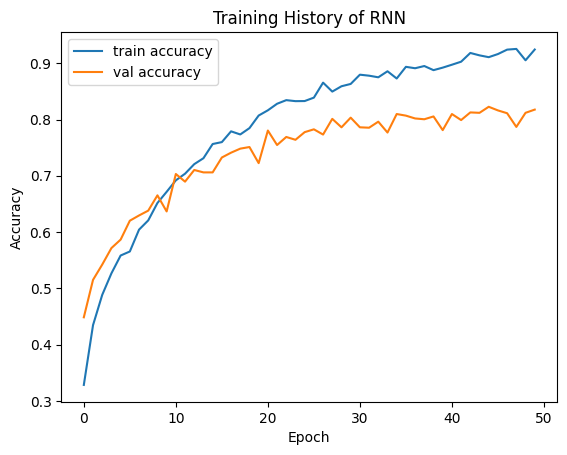

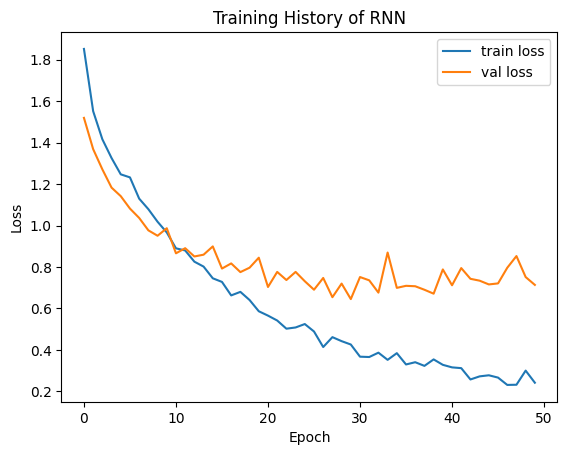

In [20]:
plt.plot(history_rnn["accuracy"], label="train accuracy")
plt.plot(history_rnn["val_accuracy"], label="val accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Training History of RNN")
plt.legend()
plt.show()

plt.plot(history_rnn["loss"], label="train loss")
plt.plot(history_rnn["val_loss"], label="val loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training History of RNN")
plt.legend()
plt.show()

# Improved RNN

In [21]:
# Build improved RNN model
improved_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(10, activation='softmax')  # 10 classes for music genres
])

# Compile improved model
improved_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [22]:
# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train improved model
improved_history = improved_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate improved model
improved_loss, improved_accuracy = improved_model.evaluate(X_test, y_test)
print(f"Improved Test Loss: {improved_loss}")
print(f"Improved Test Accuracy: {improved_accuracy}")

Epoch 1/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - accuracy: 0.1721 - loss: 3.3018 - val_accuracy: 0.3977 - val_loss: 2.3062 - learning_rate: 0.0010
Epoch 2/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - accuracy: 0.2695 - loss: 2.6609 - val_accuracy: 0.4278 - val_loss: 1.9963 - learning_rate: 0.0010
Epoch 3/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.3205 - loss: 2.3592 - val_accuracy: 0.4492 - val_loss: 1.8199 - learning_rate: 0.0010
Epoch 4/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.3351 - loss: 2.2223 - val_accuracy: 0.4607 - val_loss: 1.7522 - learning_rate: 0.0010
Epoch 5/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - accuracy: 0.3522 - loss: 2.0807 - val_accuracy: 0.4585 - val_loss: 1.6711 - learning_rate: 0.0010
Epoch 6/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.3666 - loss: 1.9647 - val_accuracy: 0.4635 - val_loss: 1.6047 - learning_rate: 0.0010
Epoch 7/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - accuracy: 0.3730 - l

In [23]:
history_rnn_improved = {"accuracy": improved_history.history["accuracy"],
                        "val_accuracy": improved_history.history["val_accuracy"],
                        "loss": improved_history.history["loss"],
                        "val_loss": improved_history.history["val_loss"]}

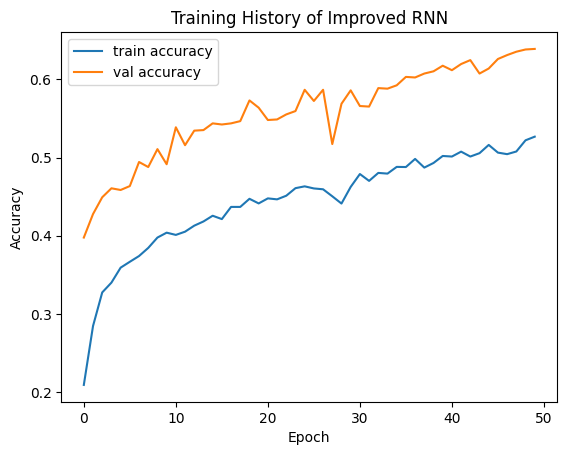

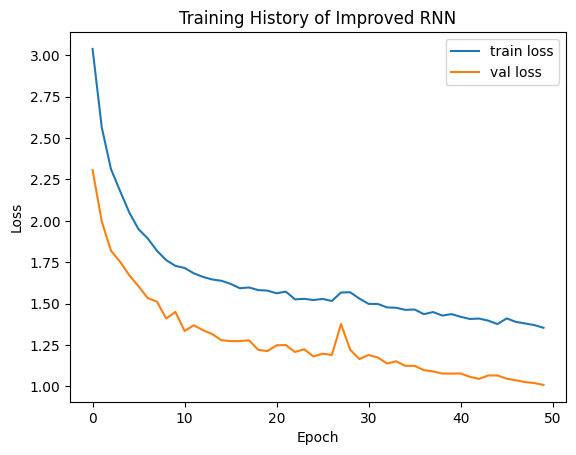

In [24]:
plt.plot(history_rnn_improved["accuracy"], label="train accuracy")
plt.plot(history_rnn_improved["val_accuracy"], label="val accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Training History of Improved RNN")
plt.legend()
plt.show()

plt.plot(history_rnn_improved["loss"], label="train loss")
plt.plot(history_rnn_improved["val_loss"], label="val loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training History of Improved RNN")
plt.legend()
plt.show()

# Comparison

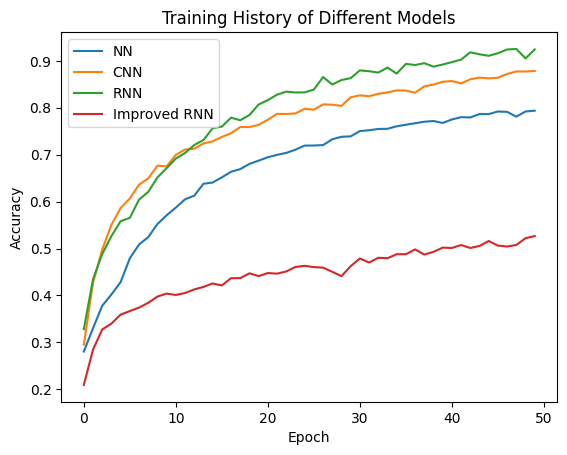

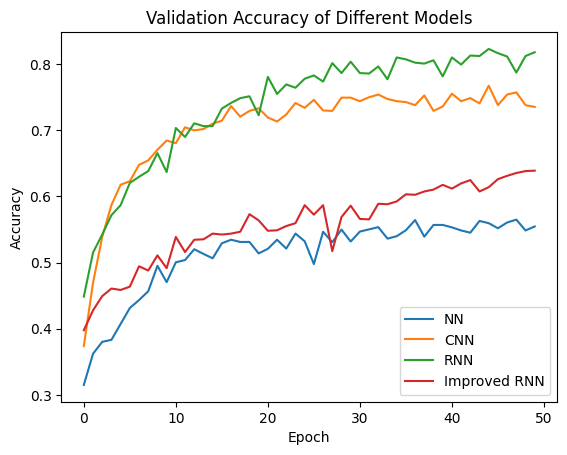

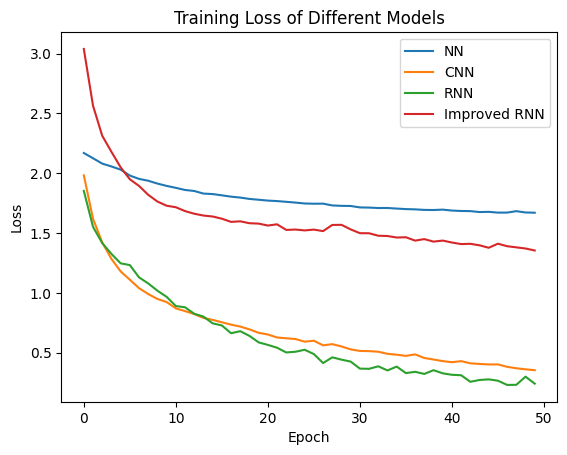

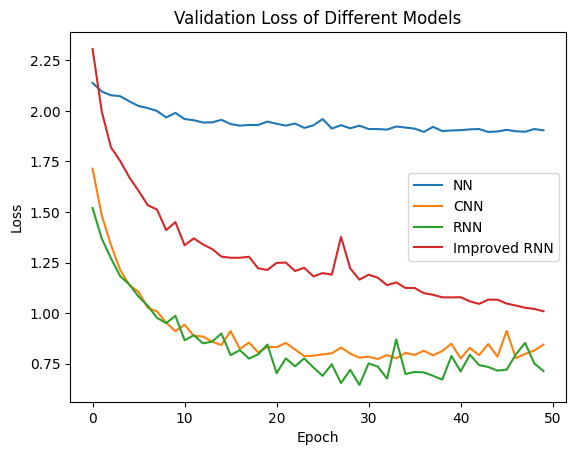

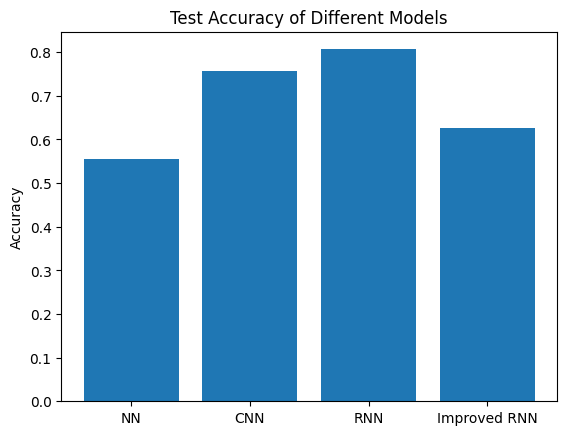

In [25]:
plt.plot(history_nn["accuracy"], label="NN")
plt.plot(history_cnn["accuracy"], label="CNN")
plt.plot(history_rnn["accuracy"], label="RNN")
plt.plot(history_rnn_improved["accuracy"], label="Improved RNN")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Training History of Different Models")
plt.legend()
plt.show()

plt.plot(history_nn["val_accuracy"], label="NN")
plt.plot(history_cnn["val_accuracy"], label="CNN")
plt.plot(history_rnn["val_accuracy"], label="RNN")
plt.plot(history_rnn_improved["val_accuracy"], label="Improved RNN")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Validation Accuracy of Different Models")
plt.legend()
plt.show()

plt.plot(history_nn["loss"], label="NN")
plt.plot(history_cnn["loss"], label="CNN")
plt.plot(history_rnn["loss"], label="RNN")
plt.plot(history_rnn_improved["loss"], label="Improved RNN")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training Loss of Different Models")
plt.legend()
plt.show()

plt.plot(history_nn["val_loss"], label="NN")
plt.plot(history_cnn["val_loss"], label="CNN")
plt.plot(history_rnn["val_loss"], label="RNN")
plt.plot(history_rnn_improved["val_loss"], label="Improved RNN")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Validation Loss of Different Models")
plt.legend()
plt.show()

plt.bar(["NN", "CNN", "RNN", "Improved RNN"], [test_accuracy_nn, test_accuracy_cnn, model_accuracy, improved_accuracy])
plt.ylabel("Accuracy")
plt.title("Test Accuracy of Different Models")
plt.show()

